In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.optimize import minimize

# Options

An option stands as a financial derivative, granting the holder the right, without obligation, to purchase an underlying asset such as a stock.

Derivatives derive their value from an underlying asset, with key parameters influencing valuation:

- **Underlying Asset Price**
- **Volatility of Underlying Asset (Standard Deviation)**
- **Time Until Expiration of Derivative**
- **Strike Price (a threshold value for options, elaborated in subsequent sections)**
- **Risk-Free Interest Rate**

This analysis focuses on European options, offering the buyer the option to buy or sell a specific stock at a predetermined price on a designated date. A *Call option* provides the right to buy, while a *Put option* gives the right to sell. Two prevalent methods for determining option prices are the Binomial Lattice and Black-Scholes models.

## Binomial Lattice (European Call Option)

The Binomial Lattice model simplifies pricing by assuming that a stock either increases or decreases by a certain amount within a given time period. The model posits a random path for stock prices, representing potential stock prices at different points in time. The fair price of an option is recursively computed based on these time steps, incorporating the principles of discounting over time using a risk-free interest rate denoted as $r$. The option's price relies on the Strike price ($K$) and the initial Stock price ($S$).



We assume for each time-period a stock goes up or down a certain percentage. These movements are defined by $u$ (Up scenario) and $d$ (Down scenario), where $u > 1$ and $d < 1$. How far a stock can move will depend on the volatility $\sigma$ and the time-period $\Delta t$.

$u = e^{\sigma \sqrt{\Delta}t}$

$d = e^{-\sigma \sqrt{\Delta}t}$

In [2]:
var = 0.2 # Variance
sigma = np.sqrt(var) # Standard deviation
S = 44 # Stock price
K = 45 # Strike price
T = 2/12 # Time period (two months = two steps)
r = 0.06 # Risk-free interest rate
delta_t = 1/12 # time-steps of one month
R = np.exp(r * delta_t) # Discounted interest

u = np.exp(sigma*np.sqrt(delta_t)) # Up scenario
d = np.exp(-sigma*np.sqrt(delta_t)) # Down scenario

def price_binomial(R, Pu, Pd, u, d):
    """ Compute option price for a step """
    q = (R-d)/(u-d)
    return (1/R) * (q * Pu + (1-q)*Pd)

### Two-step call option price

As a simple example we compute the price of a call option based on two steps of one month. This requires us to start at the end of the tree and compute $C_{ud}$ (One up scenario and one down), $C_{uu}$ (Two times down) and $C_{dd}$ (Two times up). These are all the possible scenarios after two time steps. We then use the result to compute $C_u$ and $C_d$, which are all the scenarios after one step. After this we can finally calculate $C$, which denotes the fair price of an option given all possible scenarios. Note that this setup is very simple and does not reflect reality where many other scenarios can happen. Still, the Binomial lattice gives us a good indication on how much an option if worth. Professional option traders will run software with many more time-steps and run the calculations for various values of $u$ and $d$.

$C_{ud} = max\{Sud - K, 0\}$

$C_{uu} = max\{Su^2 - K, 0\}$

$C_{dd} = max\{Sd^2 - K, 0\}$

$C_u = \frac{1}{R}(q C_{uu} + (1-q)C_{ud})$

$C_d = \frac{1}{R}(q C_{ud} + (1-q)C_{dd})$

$C = \frac{1}{R}(q C_{u} + (1-q)C_{d})$


where $q = \frac{R - d}{u - d}$ and $R = e^{r \Delta t}$.

In [3]:
c_ud = np.maximum(0, u * d * S - K)
c_uu = np.maximum(0, u**2 * S - K)
c_dd = np.maximum(0, d**2 * S - K)

In [4]:
Cu = price_binomial(R, c_uu, c_ud, u, d)
print(f"Option price for 1-step up scenario: {Cu.round(2)}")

Option price for 1-step up scenario: 5.8


In [5]:
Cd = price_binomial(R, c_ud, c_dd, u, d)
print(f"Option price for 1-step down scenario: {Cd.round(2)}")

Option price for 1-step down scenario: 0.0


In [6]:
C = price_binomial(R, Cu, Cd, u, d)
print(f"Fair option price given all scenario's: {C.round(2)}")

Fair option price given all scenario's: 2.81


## Binomial Lattice plotting

To get a clearer overview of the binomial lattice we can visualize the tree on which price calculation is based. It also allows us to analyze what returns are assumed for the up and down scenario after a time step.

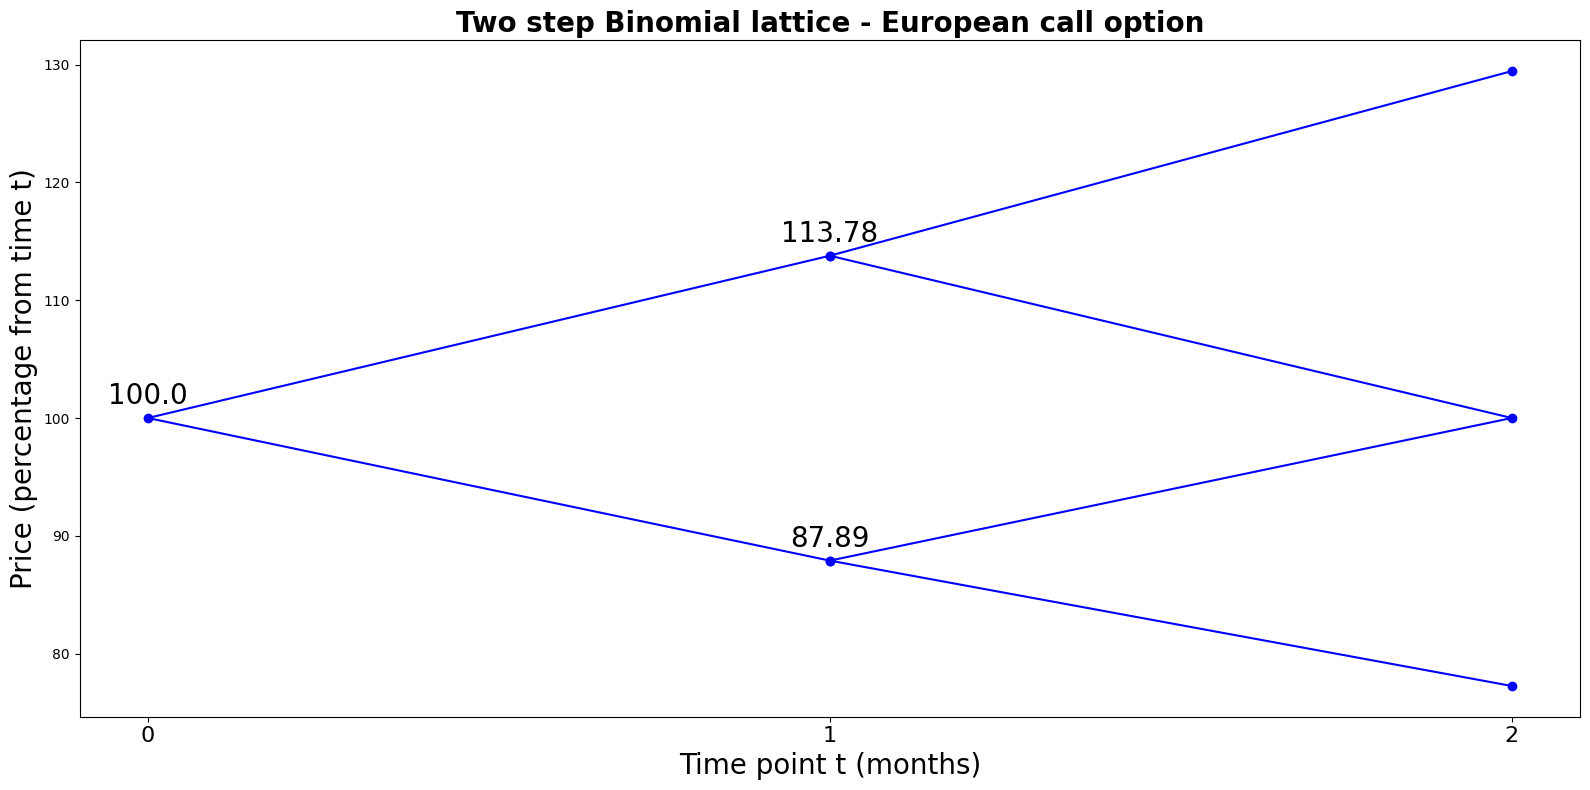

In [7]:
fig = plt.figure(figsize=[16, 8])
for i in range(2):
    x = [1, 0, 1]
    for j in range(i):
        x.append(0)
        x.append(1)
    x = np.array(x) + i
    y = np.arange(-(i+1), i+2)[::-1]
    y = 100 * np.power(u, y)
    plt.plot(x, y, 'bo-')
    if i % 2 == 0:
        for x_pos, y_value in zip(x,y):
            plt.annotate(y_value.round(2), 
                         (x_pos, y_value), 
                         textcoords="offset points",
                         xytext=(0, 10), 
                         ha='center', fontsize=20)
plt.xlabel('Time point t (months)', fontsize=20)
plt.ylabel('Price (percentage from time t)', fontsize=20)
plt.xticks([0, 1, 2], fontsize=16)
plt.title('Two step Binomial lattice - European call option', fontsize=20, weight='bold')
plt.tight_layout()

## Black-Scholes

Black-Scholes is a formula to derive the price of an option based on stochastic calculus.

$S_t$ = Stock price at time $t$, $K$ = Strike price of option, $T$ is time till expiration in years, $r$ = risk-free interest rate $\sigma$ = standard deviation (i.e. volatility).

$\Phi$ denotes the Cumulative Density Function (CDF) of the standard normal distribution ($N(0, 1)$).


$C(S_t, t) = \Phi(d_1^{(t)})S_t - \Phi(d_2^{(t)})Ke^{-rT}$

$P(S_t, t) = \Phi(-d_2^{(t)})Ke^{-rT} - \Phi(-d_1^{(t)})S_t$

where $d_1^{(t)} = \frac{1}{\sigma \sqrt{T}}[ln(\frac{S_t}{K}) + (r+\frac{\sigma^2}{2})T]$

$d_2^{(t)} = d_1^{(t)} - \sigma \sqrt{T}$

In [8]:
class BlackScholes:
    """ 
    Class to calculate (European) call and put option prices through the Black-Scholes formula 
    without dividends
    
    :S: Price of underlying stock
    :K: Strike price
    :T: Time till expiration (in years)
    :r: Risk-free interest rate (0.05 indicates 5%)
    :sigma: Volatility (standard deviation) of stock (0.15 indicates 15%)
    """
    @staticmethod
    def _d1(S, K, T, r, sigma):
        return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
    def _d2(self, S, K, T, r, sigma):
        return self._d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    def call_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a call option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r*T)
    
    def put_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a put option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(-d2) * K * np.exp(-r*T) - norm.cdf(-d1) * S
    
    def call_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that call option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d2)
    
    def put_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that put option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return 1 - norm.cdf(d2)

In [9]:
S = 44 # Stock price
K = 45 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.06 # Risk-free interest rate
sigma = np.sqrt(0.2) # Volatility (standard deviation)

In [10]:
BlackScholes().call_price(S, K, T, r, sigma)

2.9518170207100383

In [11]:
BlackScholes().put_price(S, K, T, r, sigma)

3.5040595394226024

### Probability of option ending in the money

We will show how you can use Black-Scholes to compute the theoretical probability of an option ending in the money. In the money means the option has a value at expiration. For a call option this means that the underlying stock price $S$ is higher than the strike price $K$ at experition. For a put option the stock price must be lower than the strike price. Note that this measure is solely dependent on the CDF of the Standard Normal distribution $N(0, 1)$.

Probability call is in the money = $\Phi(d_2^{(t)})$

In [12]:
BlackScholes().call_in_the_money(S, K, T, r, sigma)

0.43659661712317027

Probability put is in the money = $1 - \Phi(d_2^{(t)})$

In [13]:
BlackScholes().put_in_the_money(S, K, T, r, sigma)


0.5634033828768297